In [1]:
"""# authenticate google drive
from google.colab import drive
drive.mount('/content/drive')
"""

Mounted at /content/drive


In [ ]:
# install necessary libraries
#!pip install pyrsgis

In [1]:
# import all the required libraries
import os, glob, re, time
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import resample

#os.chdir(r'/content/drive/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')
os.chdir(r'G:/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')

In [2]:
# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [3]:
# read dataframe
df = pd.read_csv('Kathmandu_UGM_GWLR.zip', compression='zip')
df.columns = [a.split('@')[0] for a in df.keys()]

# one-hot-encode the aspect and landcover layer
for n in range(1, 9):
  df['aspect_%d'%n] = (df.aspect == n).astype(int)

for year in [2000, 2010, 2020]:
  df['%d_built'%year] = (df['%d_landcover' % (year)] == 1).astype(int).astype(int)
  df['%d_veg'%year] = (df['%d_landcover' % (year)] == 2).astype(int).astype(int)
  df['%d_agri'%year] = (df['%d_landcover' % (year)] == 3).astype(int).astype(int)

df['growth_00_10'] = df['2010_built'] - df['2000_built']
df['growth_10_20'] = df['2020_built'] - df['2010_built']

df = df[sorted_nicely(df.keys())]

print(df.keys())

Index(['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_agri', '2000_built', '2000_dist_builtup',
       '2000_landcover', '2000_roaddist_r1', '2000_roaddist_r2',
       '2000_roaddist_r3', '2000_veg', '2010_BD_K3', '2010_BD_K5',
       '2010_BD_K7', '2010_BD_K9', '2010_BD_K11', '2010_BD_K13', '2010_agri',
       '2010_built', '2010_dist_builtup', '2010_landcover', '2010_roaddist_r1',
       '2010_roaddist_r2', '2010_roaddist_r3', '2010_veg', '2020_BD_K3',
       '2020_BD_K5', '2020_BD_K7', '2020_BD_K9', '2020_BD_K11', '2020_BD_K13',
       '2020_agri', '2020_built', '2020_dist_builtup', '2020_landcover',
       '2020_roaddist_r1', '2020_roaddist_r2', '2020_roaddist_r3', '2020_veg',
       'aspect', 'aspect_1', 'aspect_2', 'aspect_3', 'aspect_4', 'aspect_5',
       'aspect_6', 'aspect_7', 'aspect_8', 'dist_bus_stops', 'dist_hospitals',
       'dist_hotels', 'dist_institutes', 'dist_water', 'elevation',
       'growth_00_10', 'growth_10_

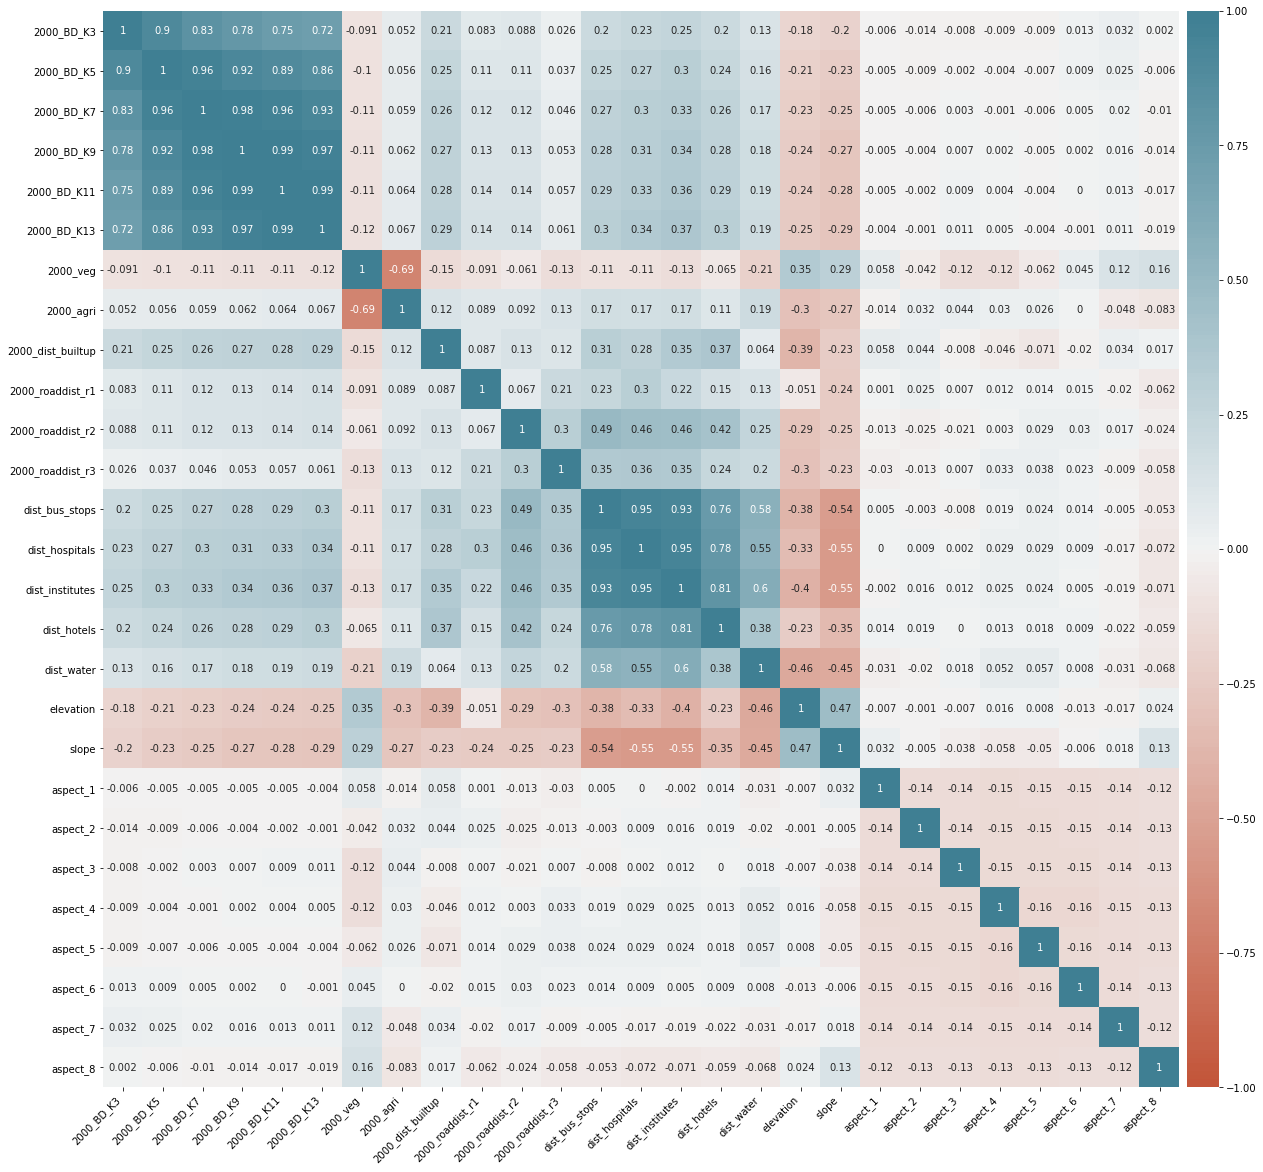

In [4]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch1 = df[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_built', '2000_veg', '2000_agri', '2000_dist_builtup',
       '2000_roaddist_r1', '2000_roaddist_r2', '2000_roaddist_r3', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope',  'aspect_1', 'aspect_2', 'aspect_3', 'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8', 'growth_00_10']]

# extract non-builtup cells only and remove builtup column
df_epoch1 = df_epoch1.loc[df_epoch1['2000_built'] == 0]
growth_00_10 = df_epoch1['growth_00_10']
df_epoch1.drop(['2000_built', 'growth_00_10'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr1 = df_epoch1.corr()
corr1 = np.round(corr1, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (20, 20))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr1,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#plt.savefig(r'Images/210727_CorrMat_Epoch1_PT_V1.png', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
corr1[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1)

2000_BD_K3           0.227667
2000_BD_K5           0.273000
2000_BD_K7           0.297333
2000_BD_K9           0.314000
2000_BD_K11          0.326333
2000_BD_K13          0.336333
2000_veg            -0.115000
2000_agri            0.171000
2000_dist_builtup    0.311667
2000_roaddist_r1     0.251333
2000_roaddist_r2     0.471000
2000_roaddist_r3     0.356667
dist_bus_stops       0.961000
dist_hospitals       0.966333
dist_institutes      0.961333
dist_hotels          0.780667
dist_water           0.572667
elevation           -0.372333
slope               -0.546667
aspect_1             0.001000
aspect_2             0.007333
aspect_3             0.002000
aspect_4             0.024333
aspect_5             0.025667
aspect_6             0.009333
aspect_7            -0.013667
aspect_8            -0.065333
dtype: float64

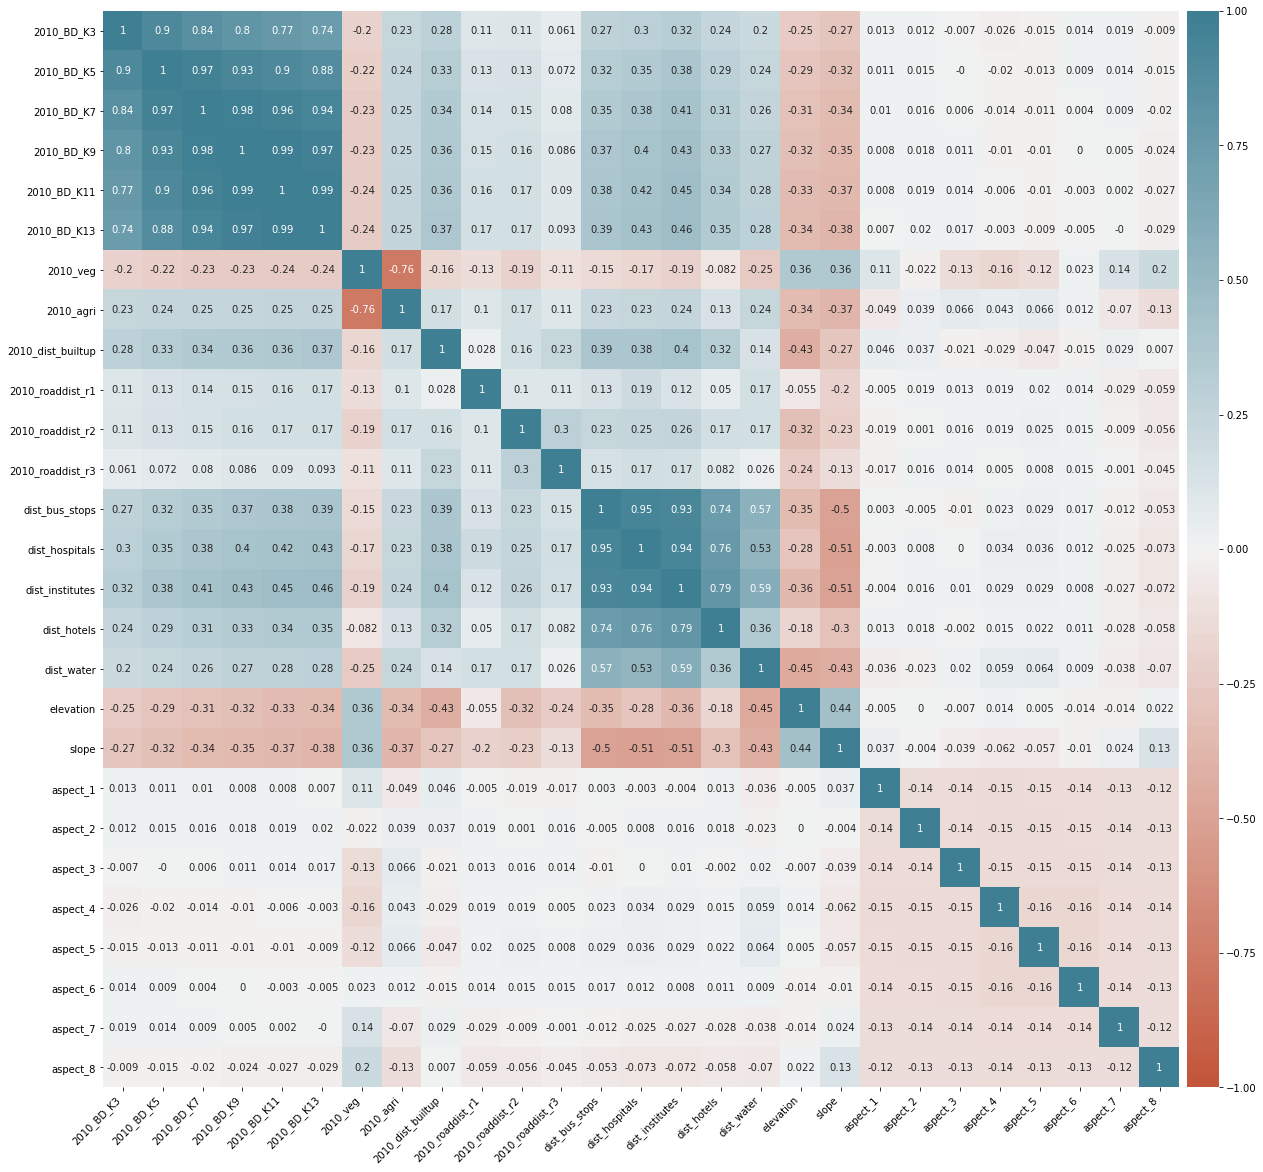

In [6]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch2 = df[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_built', '2010_veg', '2010_agri', '2010_dist_builtup',
       '2010_roaddist_r1', '2010_roaddist_r2', '2010_roaddist_r3', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope',  'aspect_1', 'aspect_2', 'aspect_3', 'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8', 'growth_10_20']]

# extract non-builtup cells only and remove builtup column
df_epoch2 = df_epoch2.loc[df_epoch2['2010_built'] == 0]
growth_10_20 = df_epoch2['growth_10_20']
df_epoch2.drop(['2010_built', 'growth_10_20'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr2 = df_epoch2.corr()
corr2 = np.round(corr2, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (20, 20))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#plt.savefig(r'Images/210727_CorrMat_Epoch2_PT_V1.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
corr2[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1)

2010_BD_K3           0.296333
2010_BD_K5           0.350667
2010_BD_K7           0.380333
2010_BD_K9           0.400667
2010_BD_K11          0.416000
2010_BD_K13          0.428000
2010_veg            -0.170667
2010_agri            0.234667
2010_dist_builtup    0.388000
2010_roaddist_r1     0.148667
2010_roaddist_r2     0.245333
2010_roaddist_r3     0.162667
dist_bus_stops       0.959667
dist_hospitals       0.964000
dist_institutes      0.959000
dist_hotels          0.765000
dist_water           0.560667
elevation           -0.330333
slope               -0.506667
aspect_1            -0.001333
aspect_2             0.006333
aspect_3             0.000000
aspect_4             0.028667
aspect_5             0.031333
aspect_6             0.012333
aspect_7            -0.021333
aspect_8            -0.066000
dtype: float64

# Feature Selection Using Random Forest - Epoch 1

## Data preparation for epoch 1

In [8]:
# remove the ones with correlation more than 0.7
# retain dist_institutes because that has the highest correlation with distance to bus stops, hospitals and hotels
df_epoch1_reduced = df_epoch1[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_veg', '2000_agri', '2000_dist_builtup',
       '2000_roaddist_r1', '2000_roaddist_r2', '2000_roaddist_r3', 'dist_hospitals', 'dist_hotels',
       'dist_water', 'elevation', 'slope', 'aspect_1', 'aspect_2', 'aspect_3',
       'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8']]

print(df_epoch1_reduced.head())

   2000_BD_K3  2000_BD_K5  2000_BD_K7  2000_BD_K9  2000_BD_K11  2000_BD_K13  \
0    0.111111        0.04    0.020408    0.024691     0.024793     0.017751   
2    0.111111        0.08    0.061224    0.037037     0.024793     0.017751   
3    0.111111        0.12    0.061224    0.037037     0.024793     0.017751   
6    0.111111        0.08    0.040816    0.024691     0.024793     0.017751   
7    0.000000        0.04    0.040816    0.024691     0.016529     0.017751   

   2000_veg  2000_agri  2000_dist_builtup  2000_roaddist_r1  ...  elevation  \
0         1          0           1.000000          0.705927  ...   0.133512   
2         1          0           1.000000          0.712461  ...   0.124397   
3         1          0           1.000000          0.715728  ...   0.120107   
6         0          1           1.000000          0.725529  ...   0.105094   
7         0          1           0.992806          0.728796  ...   0.102413   

      slope  aspect_1  aspect_2  aspect_3  aspect_

## Class balance for epoch 1

In [9]:
# Separate and balance the classes
built_features = df_epoch1_reduced.loc[growth_00_10==1]
built_labels = growth_00_10.loc[growth_00_10==1]

unbuilt_features = df_epoch1_reduced.loc[growth_00_10==0]
unbuilt_labels = growth_00_10.loc[growth_00_10==0]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = built_features.shape[0], # match minority n
                          random_state = 2)

print('Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch1_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_00_10 = pd.concat([built_labels, unbuilt_labels], axis=0)

Number of records in each class:
Built: 70529, Unbuilt: 856020
Number of records in balanced classes:
Built: 70529, Unbuilt: 70529


## LR grid search for epoch 1

In [ ]:
# perform the grid search to find the right parameters for EF epoch 1 model
param_grid_epoch1 = [
    {'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4, 5]}
]

# run grid search for the RF model
logit_epoch1 = LogisticRegression(solver='liblinear', random_state=0)
grid_search_epoch1 = GridSearchCV(logit_epoch1, param_grid_epoch1, cv=5, scoring='f1', n_jobs=-1)

grid_search_epoch1.fit(df_epoch1_reduced, growth_00_10)

In [ ]:
print(grid_search_epoch1.best_params_)

## Data preparation for epoch 2

In [10]:
df_epoch2_reduced = df_epoch2[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_veg', '2010_agri', '2010_dist_builtup',
       '2010_roaddist_r1', '2010_roaddist_r2', '2010_roaddist_r3', 'dist_hospitals', 'dist_hotels',
       'dist_water', 'elevation', 'slope', 'aspect_1', 'aspect_2', 'aspect_3',
       'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8']]

print(df_epoch2_reduced.head())

   2010_BD_K3  2010_BD_K5  2010_BD_K7  2010_BD_K9  2010_BD_K11  2010_BD_K13  \
0    0.111111        0.04    0.020408    0.024691     0.024793     0.017751   
2    0.111111        0.08    0.061224    0.037037     0.024793     0.017751   
3    0.111111        0.12    0.061224    0.037037     0.024793     0.017751   
6    0.111111        0.08    0.040816    0.024691     0.024793     0.017751   
7    0.000000        0.04    0.040816    0.024691     0.016529     0.017751   

   2010_veg  2010_agri  2010_dist_builtup  2010_roaddist_r1  ...  elevation  \
0         1          0           1.000000          0.701131  ...   0.133512   
2         1          0           1.000000          0.707772  ...   0.124397   
3         1          0           1.000000          0.711092  ...   0.120107   
6         1          0           1.000000          0.721053  ...   0.105094   
7         1          0           0.992806          0.724374  ...   0.102413   

      slope  aspect_1  aspect_2  aspect_3  aspect_

## Class balance for epoch 2

In [11]:
# Separate and balance the classes
built_features = df_epoch2_reduced.loc[growth_10_20==1]
built_labels = growth_10_20.loc[growth_10_20==1]

unbuilt_features = df_epoch2_reduced.loc[growth_10_20==0]
unbuilt_labels = growth_10_20.loc[growth_10_20==0]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = built_features.shape[0], # match minority n
                          random_state = 2)

print('Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch2_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_10_20 = pd.concat([built_labels, unbuilt_labels], axis=0)

Number of records in each class:
Built: 53042, Unbuilt: 802978
Number of records in balanced classes:
Built: 53042, Unbuilt: 53042


## RF grid search for epoch 2

In [14]:
# perform the grid search to find the right parameters for EF epoch 2 model
param_grid_epoch2 = [
    {'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4, 5]}
]

# run grid search for the RF model
logit_epoch2 = LogisticRegression(solver='liblinear', random_state=0)
grid_search_epoch2 = GridSearchCV(logit_epoch2, param_grid_epoch2, cv=5, scoring='f1', n_jobs=-1)

grid_search_epoch2.fit(df_epoch2_reduced, growth_10_20)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [1, 2, 3, 4, 5], 'penalty': ['l1', 'l2']}],
             scoring='f1')

In [15]:
print(grid_search_epoch2.best_params_)

{'C': 2, 'penalty': 'l2'}


## RF for feature selection for both the epochs

In [12]:
# fit the RF model for epoch 1
lr_epoch1 = LogisticRegression(C=1, penalty='l2', n_jobs=-1)
lr_epoch1.fit(df_epoch1_reduced, growth_00_10)

# fit the RF model for epoch 2
lr_epoch2 = LogisticRegression(C=2, penalty='l2', n_jobs=-1)
lr_epoch2.fit(df_epoch2_reduced, growth_10_20)

LogisticRegression(C=2, n_jobs=-1)

In [132]:
sns.diverging_palette(20, 220, n=10)
list(map(mpl.colors.rgb2hex, sns.diverging_palette(20, 220, n=10)))

['#c3553a',
 '#cd7862',
 '#d89a8a',
 '#e3beb4',
 '#ede0dd',
 '#dce5e8',
 '#b5ccd3',
 '#8cb1bd',
 '#6698a8',
 '#3f7f93']

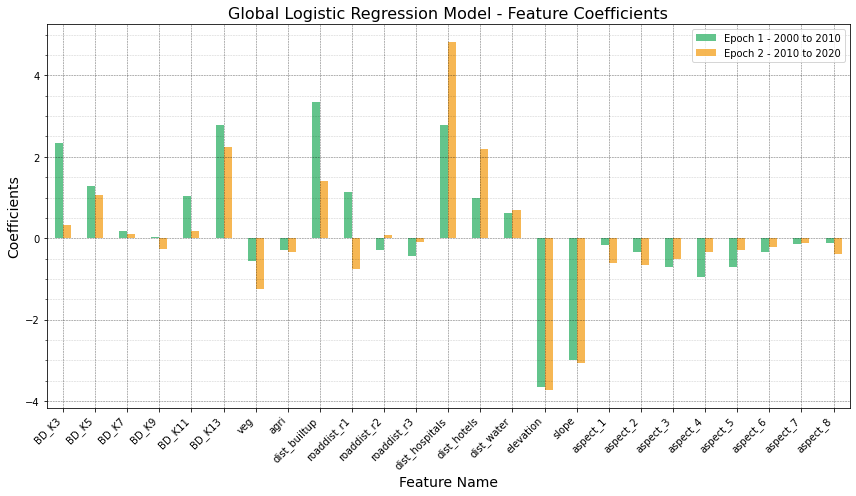

In [13]:
# get feature importance for epoch 1
importances_epoch1 = lr_epoch1.coef_.flatten()
#std_epoch1 = np.std([tree.feature_importances_ for tree in lr_epoch1.estimators_], axis=0)
lr_importances_epoch1 = pd.Series(importances_epoch1, index=df_epoch1_reduced.columns)
lr_importances_epoch1.index = lr_importances_epoch1.index.str.replace('2000_', '')
# use the below line to scale the importance
#lr_importances_epoch1 = 100*(lr_importances_epoch1.abs() / lr_importances_epoch1.abs().sum()).sort_values(ascending=False)


# get feature importance for epoch 2
importances_epoch2 = lr_epoch2.coef_.flatten()
#std_epoch2 = np.std([tree.feature_importances_ for tree in lr_epoch2.estimators_], axis=0)
lr_importances_epoch2 = pd.Series(importances_epoch2, index=df_epoch2_reduced.columns)
lr_importances_epoch2.index = lr_importances_epoch2.index.str.replace('2010_', '')
#lr_importances_epoch2 = 100*(lr_importances_epoch2.abs() / lr_importances_epoch2.abs().sum()).sort_values(ascending=False)


fig, ax = plt.subplots(figsize = (12, 7))

#importance_df = pd.concat([lr_importances_epoch1.abs(), lr_importances_epoch2.abs()], axis=1)
importance_df = pd.concat([lr_importances_epoch1, lr_importances_epoch2], axis=1)
importance_df.columns = ['Epoch 1 - 2000 to 2010', 'Epoch 2 - 2010 to 2020']

importance_df.plot.bar(ax=ax, y=["Epoch 1 - 2000 to 2010", "Epoch 2 - 2010 to 2020"], 
                       color={"Epoch 1 - 2000 to 2010":'#52BE80', "Epoch 2 - 2010 to 2020":'#F5B041'}, alpha=0.9)

ax.set_title("Global Logistic Regression Model - Feature Coefficients", fontsize=16)
ax.set_ylabel("Coefficients", fontsize=14)
ax.set_xlabel("Feature Name", fontsize=14)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.legend(loc='upper right')
plt.rc('legend', fontsize=12)

ax.grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.2)
ax.grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#ax.xaxis.grid(False)

plt.savefig(r'Images/210802_GLR_FeatImportance_BothEpochs_PT_V1.png', bbox_inches='tight', dpi=300)
fig.tight_layout()

In [14]:
importance_df

,Epoch 1 - 2000 to 2010,Epoch 2 - 2010 to 2020
BD_K3,2.345621,0.318168
BD_K5,1.291814,1.063701
BD_K7,0.165679,0.114300
BD_K9,0.017732,-0.261260
BD_K11,1.031384,0.188764
BD_K13,2.772849,2.231539
veg,-0.557778,-1.246634
agri,-0.280477,-0.335933
dist_builtup,3.357483,1.406914
roaddist_r1,1.130280,-0.747758


In [15]:
# check cumulative importance of parameters
lr_importances_epoch1 = 100*(lr_importances_epoch1.abs() / lr_importances_epoch1.abs().sum()).sort_values(ascending=False)

a = pd.concat([lr_importances_epoch1, 
               np.abs(lr_importances_epoch1).sort_values(ascending=False).cumsum(axis = 0)], axis=1)
a.columns = ['2001 Feature Importance', '2001 Cumulative Importance']
a

,2001 Feature Importance,2001 Cumulative Importance
elevation,12.976384,12.976384
dist_builtup,11.928554,24.904938
slope,10.588359,35.493297
dist_hospitals,9.916268,45.409565
BD_K13,9.851451,55.261016
BD_K3,8.333585,63.594601
BD_K5,4.589590,68.184191
roaddist_r1,4.015689,72.199880
BD_K11,3.664330,75.864210
dist_hotels,3.518623,79.382834


In [16]:
# check cumulative importance of parameters
lr_importances_epoch2 = 100*(lr_importances_epoch2.abs() / lr_importances_epoch2.abs().sum()).sort_values(ascending=False)

b = pd.concat([lr_importances_epoch2, 
               np.abs(lr_importances_epoch2).sort_values(ascending=False).cumsum(axis = 0)], axis=1)
b.columns = ['2011 Feature Importance', '2011 Cumulative Importance']
b

,2011 Feature Importance,2011 Cumulative Importance
dist_hospitals,18.750897,18.750897
elevation,14.532095,33.282992
slope,11.890589,45.173582
BD_K13,8.672618,53.846199
dist_hotels,8.481641,62.327841
dist_builtup,5.467807,67.795648
veg,4.844898,72.640546
BD_K5,4.133953,76.774498
roaddist_r1,2.906076,79.680574
dist_water,2.696040,82.376615


# Remove less important features using a K-Fold cross validation global logistic regression model--keep removing until it substantially drops

In [ ]:
## Model reduction for Epoch 1

In [19]:
# K-Fold cross validation of logit model for epoch 1
sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
x_e1, y_e1 = df_epoch1_reduced.to_numpy(), growth_00_10.to_numpy()

p_score_list = []
r_score_list = []
f1_score_list = []

n = 1
for train_index, test_index in sk_fold.split(x_e1, y_e1):
    #print('\nEvaluating fold number', n)
    x_train, x_test = x_e1[train_index], x_e1[test_index]
    y_train, y_test = y_e1[train_index], y_e1[test_index]

    lr_e1 = LogisticRegression(C=3, n_jobs=-1)
    lr_e1.fit(x_train, y_train)
    
    y_pred = lr_e1.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    #print('Confusion matrix:\n', c_matrix)
    #print('F1-Score:', f_score)
    
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f_score)
    
    n += 1
    
print('\nAverage accuracy metrics for 5-Fold Cross Validation for all features of epoch 1:')
print('Precision Score:', np.mean(p_score_list))
print('Recall Score:', np.mean(r_score_list))
print('F1-Score:', np.mean(f1_score_list))


Average accuracy metrics for 5-Fold Cross Validation for all features of epoch 1:
Precision Score: 0.8131445043428458
Recall Score: 0.8586113064133398
F1-Score: 0.8352573722025705


In [39]:
x_e1.shape

(141058, 25)

In [20]:
# K-Fold cross validation of reduced logit model for epoch 1
sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
x_e1, y_e1 = df_epoch1_reduced[['2000_BD_K3', '2000_BD_K5', '2000_BD_K11',
       '2000_BD_K13', '2000_veg', '2000_dist_builtup',
       '2000_roaddist_r1', 'dist_hospitals', 'dist_hotels',
       'dist_water', 'elevation', 'slope', 'aspect_3',
       'aspect_4', 'aspect_5']].to_numpy(), growth_00_10.to_numpy()

p_score_list = []
r_score_list = []
f1_score_list = []

n = 1
for train_index, test_index in sk_fold.split(x_e1, y_e1):
    #print('\nEvaluating fold number', n)
    x_train, x_test = x_e1[train_index], x_e1[test_index]
    y_train, y_test = y_e1[train_index], y_e1[test_index]

    lr_e1 = LogisticRegression(C=3, n_jobs=-1)
    lr_e1.fit(x_train, y_train)
    
    y_pred = lr_e1.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    #print('Confusion matrix:\n', c_matrix)
    #print('F1-Score:', f_score)
    
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f_score)
    
    n += 1
    
print('\nAverage accuracy metrics for 5-Fold Cross Validation for selected features of epoch 1:')
print('Precision Score:', np.mean(p_score_list))
print('Recall Score:', np.mean(r_score_list))
print('F1-Score:', np.mean(f1_score_list))


Average accuracy metrics for 5-Fold Cross Validation for selected features of epoch 1:
Precision Score: 0.8108931948805885
Recall Score: 0.8612485112341041
F1-Score: 0.8353108925872542


In [41]:
x_e1.shape

(141058, 15)

## Model reduction for Epoch 2

In [21]:
# K-Fold cross validation of logit model for epoch 1
sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
x_e2, y_e2 = df_epoch2_reduced.to_numpy(), growth_10_20.to_numpy()

p_score_list = []
r_score_list = []
f1_score_list = []

n = 1
for train_index, test_index in sk_fold.split(x_e2, y_e2):
    #print('\nEvaluating fold number', n)
    x_train, x_test = x_e2[train_index], x_e2[test_index]
    y_train, y_test = y_e2[train_index], y_e2[test_index]

    lr_e2 = LogisticRegression(C=2, n_jobs=-1)
    lr_e2.fit(x_train, y_train)
    
    y_pred = lr_e2.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    #print('Confusion matrix:\n', c_matrix)
    #print('F1-Score:', f_score)
    
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f_score)
    
    n += 1
    
print('\nAverage accuracy metrics for 5-Fold Cross Validation for all features of epoch 2:')
print('Precision Score:', np.mean(p_score_list))
print('Recall Score:', np.mean(r_score_list))
print('F1-Score:', np.mean(f1_score_list))


Average accuracy metrics for 5-Fold Cross Validation for all features of epoch 2:
Precision Score: 0.8217553601205575
Recall Score: 0.886655896833091
F1-Score: 0.8529675880985661


In [44]:
x_e2.shape

(106084, 25)

In [22]:
# K-Fold cross validation of reduced logit model for epoch 1
sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

reduce_keys_e2 = np.abs(lr_importances_epoch2).sort_values(ascending=False).cumsum(axis = 0)
reduce_keys_e2 = reduce_keys_e2.loc[reduce_keys_e2 < 91].index
x_e2, y_e2 = df_epoch2_reduced[['2010_BD_K5',
       '2010_BD_K13', '2010_veg', '2010_dist_builtup',
       '2010_roaddist_r1', 'dist_hospitals', 'dist_hotels',
       'dist_water', 'elevation', 'slope', 'aspect_1', 'aspect_2', 'aspect_3',
       'aspect_8']].to_numpy(), growth_10_20.to_numpy()

p_score_list = []
r_score_list = []
f1_score_list = []

n = 1
for train_index, test_index in sk_fold.split(x_e2, y_e2):
    #print('\nEvaluating fold number', n)
    x_train, x_test = x_e2[train_index], x_e2[test_index]
    y_train, y_test = y_e2[train_index], y_e2[test_index]

    lr_e2 = LogisticRegression(C=2, n_jobs=-1)
    lr_e2.fit(x_train, y_train)
    
    y_pred = lr_e2.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    #print('Confusion matrix:\n', c_matrix)
    #print('F1-Score:', f_score)
    
    p_score_list.append(p_score)
    r_score_list.append(r_score)
    f1_score_list.append(f_score)
    
    n += 1
    
print('\nAverage accuracy metrics for 5-Fold Cross Validation for selected features of epoch 2:')
print('Precision Score:', np.mean(p_score_list))
print('Recall Score:', np.mean(r_score_list))
print('F1-Score:', np.mean(f1_score_list))


Average accuracy metrics for 5-Fold Cross Validation for selected features of epoch 2:
Precision Score: 0.8212544918512105
Recall Score: 0.8866936060008811
F1-Score: 0.8527174317459483


In [61]:
x_e2.shape

(106084, 14)

['dist_hospitals',
 'elevation',
 'slope',
 'BD_K13',
 'dist_hotels',
 'dist_builtup',
 'veg',
 'BD_K5',
 'roaddist_r1',
 'dist_water',
 'aspect_2',
 'aspect_1',
 'aspect_3',
 'aspect_8']